<a href="https://colab.research.google.com/github/charupandey-codes/Modeling-an-fMRI-time-series/blob/main/WW_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Nov  1 10:49:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install cupy-cuda12x

In [3]:
!pip install vbi

In [4]:
!pip install cmaes

In [5]:
!pip install sbi

In [6]:
import os
import vbi
import torch
import warnings
import numpy as np
import pandas as pd
from cmaes import CMA
import networkx as nx
import sbi.utils as utils
from copy import deepcopy
from vbi.utils import timer
import multiprocessing as mp
import matplotlib.pyplot as plt
from vbi.sbi_inference import Inference
from vbi.models.cupy.ww import WW_sde
from vbi.feature_extraction.features_utils import get_fcd
from vbi import (
    extract_features,
    get_features_by_domain,
    get_features_by_given_names,
    update_cfg,
)

warnings.simplefilter("ignore")

In [7]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

LABESSIZE = 10
plt.rcParams["axes.labelsize"] = LABESSIZE
plt.rcParams["xtick.labelsize"] = LABESSIZE
plt.rcParams["ytick.labelsize"] = LABESSIZE

In [8]:
path = "output"
os.makedirs("output/ww_full", exist_ok=True)

In [9]:
def wrapper(par):
    ''' Wrapper function to run the WW_sde model with given parameters.'''
    par = deepcopy(par)
    sde = WW_sde(par)
    data = sde.run()
    S_t = data["t"]
    S_d = data["S"]
    bold_d = data["bold_d"]
    bold_t = data["bold_t"]
    if par["RECORD_S"]:
        return S_t, S_d, bold_t, bold_d
    else:
        return bold_t, bold_d

In [10]:
# --- define feature extraction configuration ---

cfg = get_features_by_domain("connectivity")
cfg = get_features_by_given_names(cfg, ["fcd_stat"])
cfg = update_cfg(cfg, "fcd_stat", parameters={"k": None, "win_len": 30, "TR": 0.5})
# report_cfg(cfg)

In [11]:
# --- load connectivity matrix ---

D = vbi.LoadSample(nn=88)
weights = D.get_weights()
nn = weights.shape[0]
print(f"number of nodes: {nn}")

number of nodes: 88


In [12]:
# --- Simulation Parameters ---

params = {
    "weights": weights,
    "engine": "cpu", # "gpu"
    "RECORD_S": False,
    "G_exc": 1.166,
    "ext_current": 0.09,
    "num_sim": 1,
    "sigma": 0.05,
    "t_cut": 0.5 * 60 * 1000.0,
    "t_end": 3 * 60 * 1000.0,
    "s_decimate": 10,
    "dt": 2.5,
    "tr": 300.0,
    "seed": seed,
    "dtype": "float32",
}

bold_t, bold_d = wrapper(params)
bold_d = np.transpose(bold_d, (2, 1, 0))

df = extract_features(
    bold_d, 1, cfg, n_workers=10, output_type="dataframe", verbose=False
)
print(df[["fcd_full_ut_std"]].values[0])

Integrating: 100%|██████████| 72000/72000 [00:15<00:00, 4575.42it/s]


[0.1335095]


In [13]:
theta_true = [params["G_exc"], params["ext_current"]]
np.savez("output/ww_full/observation.npz", bold_t=bold_t, bold_d=bold_d, theta=theta_true)
df.to_csv("output/ww_full/observation.csv", index=False)

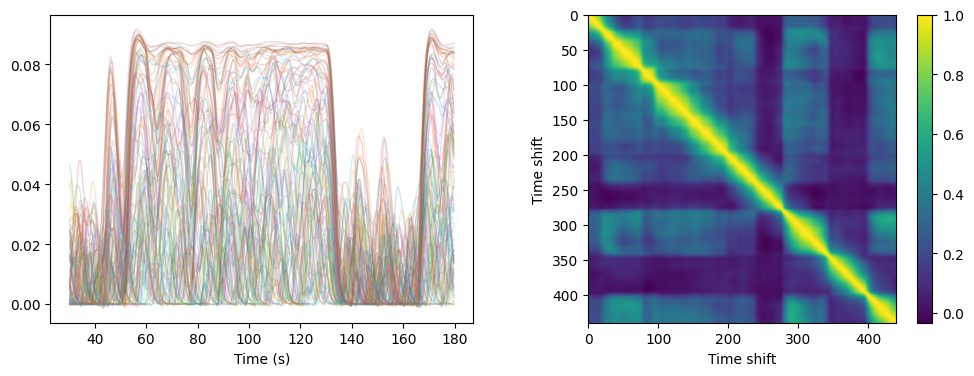

In [14]:
fcd = get_fcd(bold_d[0], win_len=30, TR=0.5)["full"]

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)
ax1.plot(bold_t/1000, bold_d[0, ...].T, lw=1, alpha=0.2)
ax1.set_xlabel('Time (s)')
ax2 = plt.subplot(122)
im = ax2.imshow(fcd, cmap="viridis", aspect="equal")
plt.colorbar(im, ax=ax2)
plt.xlabel('Time shift')
plt.ylabel('Time shift')
plt.show()

In [16]:
num_sim = 50
gmin, gmax = 0., 2.0
imin, imax = 0.0, 1.0
prior_min = [gmin, imin]
prior_max = [gmax, imax]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

obj = Inference()
theta = obj.sample_prior(prior, num_sim, seed=seed)
torch.save(theta, os.path.join(path, "theta.pt"))

In [18]:
ext_current = theta[:, 1].numpy().squeeze()
G_exc = theta[:, 0].numpy().squeeze()

params = {
    "weights": weights,
    "engine": "gpu", # "gpu"
    "RECORD_S": False,
    "G_exc": 1.166,
    "ext_current": ext_current,
    "num_sim": num_sim,
    "sigma": 0.05,
    "t_cut": 0.5 * 60 * 1000.0,
    "t_end": 3 * 60 * 1000.0,
    "s_decimate": 10,
    "dt": 2.5,
    "tr": 300.0,
    "seed": seed,
    "dtype": "float32",
}

params["G_exc"] = G_exc
params["ext_current"] = ext_current

bold_t, bold_d = wrapper(params)
bold_d = np.transpose(bold_d, (2, 1, 0))
print(bold_d.shape, bold_t.shape)

df = extract_features(
    bold_d, 1, cfg, n_workers=10, output_type="dataframe", verbose=True
)

Integrating: 100%|██████████| 72000/72000 [05:15<00:00, 227.96it/s]


(50, 88, 499) (499,)


100%|██████████| 50/50 [02:09<00:00,  2.59s/it]


In [19]:
np.savez("output/ww_full/ww_sde_data.npz", bold_t=bold_t, bold_d=bold_d, theta=theta.numpy())
df.to_pickle("output/ww_full/ww_sde_features.pickle")

In [21]:
# drop columns with low variance, keep retained column indices
remained_columns = df.std() > 0.01
df = df.loc[:, remained_columns]
x = df.values
x = torch.tensor(x, dtype=torch.float32)
torch.save(x, "output/ww_full/ww_sde_features.pt")
torch.save(prior, "output/ww_full/prior.pt")

In [22]:
remained_columns.to_csv("output/ww_full/remained_columns.csv", index=False)

In [23]:
x.shape, theta.shape

(torch.Size([50, 17]), torch.Size([50, 2]))

In [24]:
obj = Inference()
posterior = obj.train(theta, x, prior, num_threads=8)
torch.save(posterior, "output/ww_full/posterior.pt")

 Neural network successfully converged after 76 epochs.train Done in 0 hours 0 minutes 04.648876 seconds


In [30]:
# 'df' is the variable you created in the *previous* cell
# (the (100, 15) summary table)

# 1. Get the data for your "ground truth" (we'll use the first simulation)
# .values gets the numpy data, [0] selects the first row.
x_obs_numpy = df.values[0]

# 2. Convert it to the torch tensor that the AI needs
x_obs = torch.tensor(x_obs_numpy, dtype=torch.float32)

print(f"Using simulation #0 as the 'ground truth' (x_obs).")
print(f"Shape of x_obs: {x_obs.shape}")

Using simulation #0 as the 'ground truth' (x_obs).
Shape of x_obs: torch.Size([17])


In [31]:
samples = obj.sample_posterior(x_obs, 10000, posterior)

  0%|          | 0/10000 [00:00<?, ?it/s]

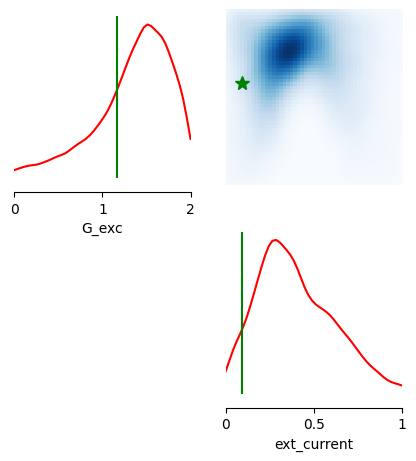

In [32]:
from sbi.analysis import pairplot

limits = [[i, j] for i, j in zip(prior_min, prior_max)]
fig, ax = pairplot(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=[theta_true],
    labels=["G_exc", "ext_current"],
    offdiag='kde',
    diag='kde',
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
    upper_kwargs={"mpl_kwargs": {"cmap": "Blues"}},
)